# Computing Krill NASC from the Pacific Hake Survey

Jupyter notebook accompanying the manuscript:

_Echopype: A Python library for interoperable and scalable processing of ocean sonar data for biological information_   
_Authors: Wu-Jung Lee, Emilio Mayorga, Landung Setiawan, Kavin Nguyen, Imran Majeed, Valentina Staneva, Caesar Tuguinay_

## Introduction

### Description

This notebook uses a 4 day subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration, regridding, and frequency differencing using [`echopype`](https://echopype.readthedocs.io) and core scientific Python software packages (particularly `xarray`, `Dask` and `NumPy`) to compute Krill attributed Nautical Areal Scattering Coefficient (NASC).

### Outline

1) Convert EK60 RAW Files to Echodata Objects
2) Combine Echodata Objects
3) Calibrate Combined Echodata Object
4) Regrid Calibrated Data
5) Remove Empty Water from Regridded Calibrated Data
6) Generate Frequency Difference Mask and Apply Mask on Non-Empty Water Regridded Calibrated Data
7) Compute Water Column Krill NASC and dB NASC
8) Plot Water Column Krill dB NASC on map

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/binder/environment.yml. The notebook creates a directory, if not already present: `./exports/krill_notebook_outputs`. Zarr files will be exported there.

### Note
We also encourage importing `echopype` as `ep` for consistency.

In [1]:
from pathlib import Path
import os

import fsspec
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # noqa

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

### Establish AWS S3 file system connection and generate list of target EK60 `.raw` files

Access and inspect the publicly accessible NCEI WCSD S3 bucket on the AWS cloud as if it were a local file system. This will be done through the Python [fsspec](https://filesystem-spec.readthedocs.io) file system and bytes storage interface. We will use `fsspec.filesystem.glob` (`fs.glob`) to generate a list of all EK60 `.raw` data files in the bucket, then filter on file names for target dates of interest. 

The directory path on the [ncei-wcsd-archive S3 bucket](https://ncei-wcsd-archive.s3.amazonaws.com/index.html) is `s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/`. All `.raw` files from the 2017 Hake survey cruise are found here.

In [2]:
# Setup filesystem
fs = fsspec.filesystem('s3', anon=True)
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

# Select all RAW files from July 2017
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")
select_files = [
    s3path
    for s3path in s3rawfiles
    if any(
        f"D2017{datestr}" in s3path
        for datestr in ["0726", "0727", "0728", "0729"]
    )
]
print(f"There are {len(select_files)} target raw files available")

There are 324 target raw files available


**NOTE:**

If you are on Binder or are running this on a machine with less than 16 GiB of RAM, we recommend you to use only a subset of the `select_files`.

In [3]:
# Uncomment the line below to use a subset of the 324 files

#select_files = select_files[0:10]

Most of the data here is stored on Disk, since it cannot fit in-memory. Please modify the `base_dpath` below to point to disk storage location where you have **at least 50 GiB** of storage space available.

Create directories to store Zarr files:

In [3]:
base_dpath = Path('./exports/krill_notebook_outputs')
base_dpath.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = Path(base_dpath / 'hake_survey_echodata_zarr')
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = Path(base_dpath / 'combined_zarr')
combined_zarr_path.mkdir(exist_ok=True)

### Dask Client Setup

Echopype uses Dask in the background to lazily load, do out-of-memory and parallelized computation on large arrays. Dask Client helps schedule tasks and allocate memory for these large array computations.

Set the `n_workers` to be such that each worker has at least 4 GiB of memory.

In [4]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count()) # Modify this so that total_RAM / n_workers >= 4
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


The following Echopype processing code follows a pattern of `to_zarr` and "open zarr" for the more computationally challenging processing stages. This patterns points computation outputs to be stored in disk instead of in memory, and when this computation is done, it lazily-loads the recently computed arrays.

### Convert EK60 RAW Files to Echodata Objects

In [5]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in select_files:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 34.3 s, sys: 8.53 s, total: 42.8 s
Wall time: 50.3 s


### Combine Echodata Objects

Under the hood of the `ep.combine_echodata` function, the Zarr Stores in each Echodata object are lazily appended together; however, since the appending is done in a time-ordered manner (i.e. older Echodata objects are appended to the intermediate combined Echodata object prior to more recent Echodata objects), the appending must be done sequentially. Hence we cannot take advantage of parallelism here so this will be the slowest stage of the Echopype processing pipeline.

In [6]:
%%time

# Open Zarr Stores containing Echodata Objects, Lazy Load them, and Lazily Combine Echodata Objects
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save to Zarr and offload computation to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazily Open Zarr
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/dataset.py:2549: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


CPU times: user 11min 53s, sys: 2min 1s, total: 13min 54s
Wall time: 14min 25s


### Calibrate Combined Echodata Object

Compute Volume Backscattering Strength (Sv), and add depth and latitude/longitude to this Xarray Dataset.

In [7]:
%%time

# Chunk Echodata Object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 40.4 s, sys: 5.33 s, total: 45.7 s
Wall time: 45.7 s


### Regrid Calibrated Data

Compute Mean Volume Backscattering Strength (MVBS). This gets our data into a 'commongrid' format where each point in the 'Echogram' covers the same ping time length and depth height as every other point.

In [8]:
%%time

# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='5m', # in meters
    ping_time_bin='20s', # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 1min 23s, sys: 20.9 s, total: 1min 44s
Wall time: 1min 53s


### Remove Empty Water from Regridded Calibrated Data

Empty water should be removed prior to creating the frequency differencing masks.

In [12]:
%%time

# Create copy of MVBS
ds_non_empty_MVBS = ds_MVBS.copy()

# Replace all Sv less -70 dB with NaN
ds_non_empty_MVBS["Sv"] = xr.where(ds_MVBS["Sv"] < -70, np.nan, ds_MVBS["Sv"])

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.8 ms


### Generate Frequency Difference Mask and Apply Mask on Non-Empty Water Regridded Calibrated Data

Compute Frequency Differencing masks using 16.2dB >= 120kHz - 38kHz >= 10.0dB to identify Krill.

These dB values are used by Phillips et al. (2022) to identify krill in water column data.

**Reference:**

Elizabeth M Phillips, Dezhang Chu, Stéphane Gauthier, Sandra L Parker-Stetter, 
Andrew O Shelton, Rebecca E Thomas, Spatiotemporal variability of euphausiids 
in the California Current Ecosystem: insights from a recently developed time series, 
ICES Journal of Marine Science, Volume 79, Issue 4, May 2022, Pages 1312–1326, 
https://doi.org/10.1093/icesjms/fsac055

In [13]:
%%time

# Compute compute both frequency differencing inequalities as separate masks
freq_diff_mask_1 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz < 16.2dB"
)
freq_diff_mask_2 = ep.mask.frequency_differencing(
    ds_non_empty_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz > 10.0dB"
)

# Apply both frequency differencing masks
ds_freq_diff_MVBS = ep.mask.apply_mask(
    ds_non_empty_MVBS,
    [freq_diff_mask_1, freq_diff_mask_2]
)

CPU times: user 930 ms, sys: 234 ms, total: 1.16 s
Wall time: 1.35 s


### Compute Water Column Krill NASC and dB NASC

Compute NASC with a distance bin of 0.5nmi and on the entire water column on the first 250m of the MVBS dataset.

In [14]:
%%time

# Compute NASC
ds_freq_diff_NASC = ep.commongrid.compute_NASC(
    # Grab only the first 250m in the MVBS
    ds_freq_diff_MVBS.sel(depth=slice(0, 250)),
    range_bin="250m",
    dist_bin="0.5nmi"
)

# Drop depth from NASC since it is just 1 entry
ds_freq_diff_NASC = ds_freq_diff_NASC.isel(
    depth=0
).drop_vars("depth")

# Compute decibel NASC using elementwise operations and add long name attribute
ds_freq_diff_NASC["dB_NASC"] = 10 * np.log10(ds_freq_diff_NASC["NASC"])
ds_freq_diff_NASC["dB_NASC"].attrs = {
    "long_name": "Decibel Nautical Areal Scattering Coefficient (dB-NASC)",
    "units": "dB m2 nmi-2"
}

# Select the 120 kHz channel
ds_freq_diff_120kHz_NASC = ds_freq_diff_NASC.sel(
    channel="GPT 120 kHz 00907205a6d0 4-1 ES120-7C"
).drop("channel")

CPU times: user 3.82 s, sys: 380 ms, total: 4.2 s
Wall time: 4.33 s


### Plot Water Column Krill dB NASC on map

In the visualization below, empty water column (NaN NASC) will be denoted with a translucent circle, and we use a dB scale to visualize the wide range of values in NASC:

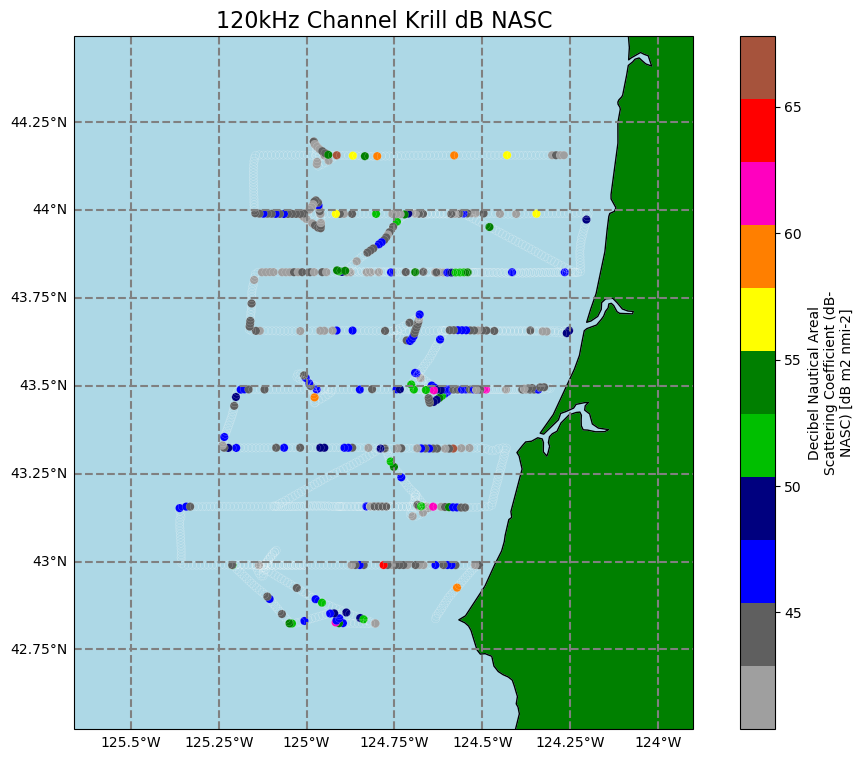

CPU times: user 13.1 s, sys: 1.15 s, total: 14.2 s
Wall time: 13.8 s


In [15]:
%%time

# Create plot
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1.5,
    color='gray',
    linestyle='--'
)
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

# Set lat lon extent
ax.set_extent([
    ds_freq_diff_120kHz_NASC["longitude"].min().values - 0.3,
    ds_freq_diff_120kHz_NASC["longitude"].max().values + 0.3,
    ds_freq_diff_120kHz_NASC["latitude"].min().values - 0.3,
    ds_freq_diff_120kHz_NASC["latitude"].max().values + 0.3,
], crs=ccrs.PlateCarree())

# Add land and ocean features
ax.add_feature(cfeature.LAND, color='green')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Plot dB NASC on map
p = ds_freq_diff_120kHz_NASC.plot.scatter(
    x="longitude",
    y="latitude",
    hue="dB_NASC",
    ax=ax,
    transform=ccrs.PlateCarree(),
    linewidths=0.1,
    cmap="ep.ek500"
)

# Set axes title
p.axes.set_title("120kHz Channel Krill dB NASC", fontsize=16)

# Show plot
plt.show()